```
This script can be used for any purpose without limitation subject to the
conditions at http://www.ccdc.cam.ac.uk/Community/Pages/Licences/v2.aspx

This permission notice and the following statement of attribution must be
included in all copies or substantial portions of this script.

2022-06-01: Made available by the Cambridge Crystallographic Data Centre.

```

# Conformer Generation

This notebook illustrates the use of the [Conformer API](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/conformer.html).

#### References

The Conformer API use CSD-derived conformational distributions to generate conformers for small molecules:
* https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/conformer.html
* https://downloads.ccdc.cam.ac.uk/documentation/API/modules/conformer_api.html

The associated publication describes the statistical validation performed, which also includes comparisons with PDB structures:
* https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00697

In addition, there is a large amount of literature describing various comparisons between CSD, PDB and computed small-molecule conformations. A sample is given below:
* https://journals.iucr.org/d/issues/2017/03/00/ba5249/ba5249.pdf
* https://link.springer.com/article/10.1007/s10822-011-9538-6
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5553890/

In [1]:
import logging
from pathlib import Path
from platform import platform
import sys
import os
from time import time
import subprocess

import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)  # Ignore current 'distutils Version classes are deprecated' warning
    
    import pandas as pd
    
    import plotly.express as px

In [3]:
from IPython.display import HTML

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
import ccdc
from ccdc.molecule import Molecule
from ccdc.entry import Entry
from ccdc.conformer import MoleculeMinimiser, ConformerGenerator
from ccdc.search import SubstructureSearch, SMARTSSubstructure
from ccdc.descriptors import MolecularDescriptors
from ccdc.diagram import DiagramGenerator
from ccdc.io import MoleculeReader, EntryReader, MoleculeWriter, EntryWriter

### Configuration

In [5]:
def run_hermes(file_names):
    hermes_exe = r'C:\Program Files\CCDC\Discovery_2022\Hermes\hermes.exe' 
    rlist = [hermes_exe] + file_names
    if os.path.exists(hermes_exe):
        status = subprocess.Popen(rlist, creationflags=0x00000008)
    else:
        print(f"Skipping visualisation in Hermes as hermes executable not available {hermes_exe}")

### Initialization

In [6]:
logger = logging.getLogger(__name__)

if not logger.hasHandlers():
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter('[%(asctime)s %(levelname)-7s] %(message)s', datefmt='%y-%m-%d %H:%M:%S'))
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [7]:
logger.info(f"""
Platform:                     {platform()}

Python exe:                   {sys.executable}
Python version:               {'.'.join(str(x) for x in sys.version_info[:3])}

CSD version:                  {ccdc.io.csd_version()}
CSD directory:                {ccdc.io.csd_directory()}
API version:                  {ccdc.__version__}

CSDHOME:                      {os.environ.get('CSDHOME', 'Not set')}
CCDC_LICENSING_CONFIGURATION: {os.environ.get('CCDC_LICENSING_CONFIGURATION', 'Not set')}
""")

Set up a CCDC Diagram Generator...

In [8]:
diagram_generator = DiagramGenerator()

diagram_generator.settings.return_type = 'SVG'
diagram_generator.settings.explicit_polar_hydrogens = False
diagram_generator.settings.shrink_symbols = False

<a id="mol_prep"></a>

### Molecule Preparation

We will be using Lapatinib as our test molecule (_N.B._ this structure is just the main component of [DINXIJ](https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DINXIJ))...

In [9]:
with MoleculeReader('lapatinib.mol2') as reader:
    
    mol = reader[0]

Depict the molecule...

In [10]:
HTML(diagram_generator.image(mol))

### Simple minimization and superimposition

First, we simply minimise our molecule and then superimpose the minimised structure onto the original.

To minimise the molecule, we use a [MoleculeMinimiser](https://downloads.ccdc.cam.ac.uk/documentation/API/modules/conformer_api.html#molecule-minimisation) object...

In [11]:
minimiser = MoleculeMinimiser()

In [12]:
minimised_mol = minimiser.minimise(mol)

Overlay the minimised structure onto the original using all heavy atoms...

In [13]:
overlay = MolecularDescriptors.Overlay(mol, minimised_mol) # , zip(mol.heavy_atoms, minimised_mol.heavy_atoms))

logger.info(f"RMSD: {overlay.rmsd:.3f}")

Export the overlayed structure...

In [14]:
overlayed_mol = overlay.molecule

overlayed_mol.identifier = 'minimised_and_overlayed'

In [15]:
with MoleculeWriter('minimised.mol2') as writer:
    
    writer.write(overlayed_mol)

Visualize the exported structures in Hermes...

In [16]:
run_hermes(['lapatinib.mol2', 'minimised.mol2'])

The original structure is in cyan, the overlayed structure in magenta. Note that the display was set up manually.

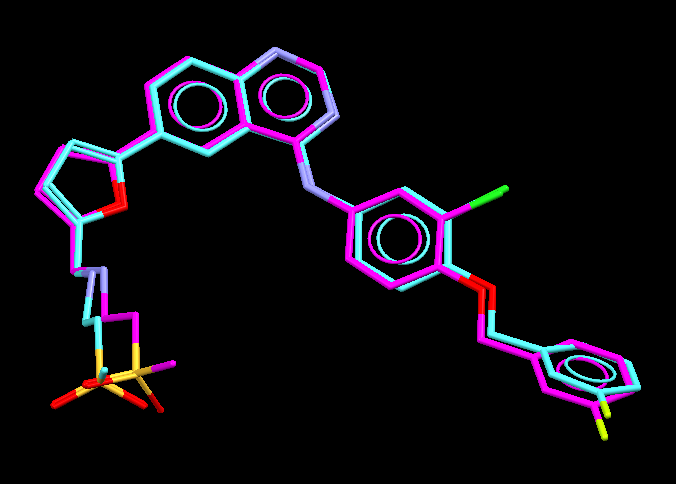

### Generating Conformers

Here we illustrate the generation of conformers for the molecule used above, using a [ConformerGenerator](https://downloads.ccdc.cam.ac.uk/documentation/API/modules/conformer_api.html#ccdc.conformer.ConformerGenerator). It can be configured _via_ it's [settings](https://downloads.ccdc.cam.ac.uk/documentation/API/modules/conformer_api.html#ccdc.conformer.ConformerSettings) attribute.

In [17]:
conformer_generator = ConformerGenerator()

conformer_generator.settings.max_conformers = 20 

The [ConformerHitList](https://downloads.ccdc.cam.ac.uk/documentation/API/modules/conformer_api.html#ccdc.conformer.ConformerHitList) object produced contains attributes relating to the overall performance of the run; for example, whether or not the sampling limit was reached and how many rotamers had no observations in the CSD.

In [18]:
conformers = conformer_generator.generate(mol)

len(conformers), conformers.sampling_limit_reached, conformers.n_rotamers_with_no_observations

#### Analysing the conformers

The individual [ConformerHit](https://downloads.ccdc.cam.ac.uk/documentation/API/modules/conformer_api.html#ccdc.conformer.ConformerHit) objects have a `normalised_score` attribute, which is a value between 0.0 (most probable) and 1.0 (least probable); conformers are listed in probability order (the most probable first). 

A method is also provided to calculate the RMSD of each conformer in the hit list with respect to the input molecule as supplied (the default) or to a minimised version of the input molecule.

In [19]:
conformers_df = pd.DataFrame(
                    data   =[(x.normalised_score,  x.rmsd(),          x.rmsd(wrt='minimised')) for x in conformers],
                    columns=['Normalized Score',  'RMSD (original)', 'RMSD (minimised)']
                )

conformers_df.shape

In [20]:
conformers_df

### Superimposition of conformers onto a substructure

Conformers can be superimposed using all atoms, exactly as shown above for the minimised structure. However, this is not usually very informative, so instead we will illustrate the superposition of the conformers generated above onto a substructure. This method better highlights the similarities and differences between conformers.
It can also be easily extended to superimpose conformers for different molecules that share a substructure, such as members of a congeneric series (although we will not illustrate this here).


A [substructure search](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/substructure_searching.html) is used to tag conformers with the substructure of interest, so we specify a substructure query for the superimposition using a SMARTS string...


In [21]:
query = 'n1cnc(N)c2ccccc12' # 4-amino quinazoline

In [22]:
searcher = SubstructureSearch()

substructure = SMARTSSubstructure(query)

In [23]:
_ = searcher.add_substructure(substructure)

tagged = searcher.search([x.molecule for x in conformers], max_hits_per_structure=1)

We use first (_i.e._ best-scoring) conformer as reference...

In [24]:
reference = tagged[0]

ref_molecule, ref_match_atoms = reference.molecule, reference.match_atoms()

Perform superimposition using substructure...

In [25]:
superimposed = [MolecularDescriptors.Overlay(ref_molecule, substructure.molecule, zip(ref_match_atoms, substructure.match_atoms())) for substructure in tagged]

Write the superimposed conformers...

In [26]:
superimposed_dir = Path('superimposed')

superimposed_dir.mkdir(exist_ok=True)

for n, conformer in enumerate(superimposed, 1):
    
    name = f'conformer_{n:03d}'
    
    superimposed_mol = conformer.molecule
    
    superimposed_mol.identifier = name
    
    superimposed_file = superimposed_dir / f'{name}.mol2'
    
    with MoleculeWriter(str(superimposed_file)) as writer:

        writer.write(superimposed_mol)        

Visualise superimposed structures in Hermes...

In [27]:
run_hermes([str(x) for x in superimposed_dir.glob('conformer_*.mol2')])

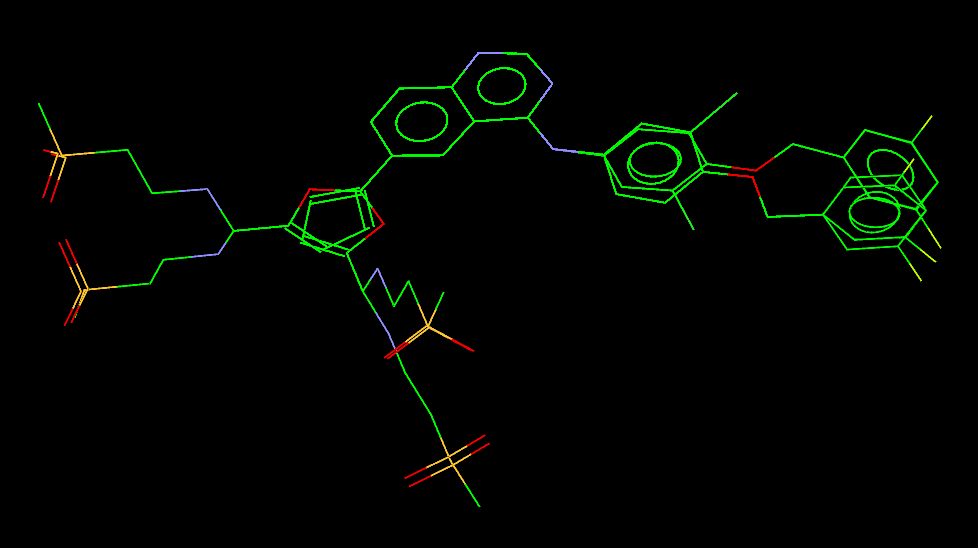

### Conformer generation for multiple molecules

Conformer generation can also be performed on input files containing multiple molecules. As noted above, we assume that the input structures are already in the desired charge and tautomeric state.

As input we will use an SDF file (see the '[Input for GOLD](../08_Docking/00a_Input_for_GOLD.ipynb)' notebook for details of its creation)...

In [28]:
input_file = 'input.sdf'

We will output the conformers to a single SDF file...

In [29]:
output_file = 'conformers.sdf'

Generate conformers using the Conformer API...

In [30]:
conformer_generator = ConformerGenerator()

conformer_generator.settings.max_conformers = 20 

conformer_generator.settings.superimpose_conformers_onto_reference = True

In [31]:
%%time

with EntryReader(str(input_file)) as reader:  # Initital 3D structure
        
    with EntryWriter(str(output_file)) as writer: # Conformers

        for entry in reader:

            mol = entry.molecule

            # Generate conformers...

            conformers = conformer_generator.generate(mol)
            
            # Write conformers to file, along with per-conformer stats...
            
            for conformer in conformers:
                
                attributes = {**entry.attributes, **{x: getattr(conformer, x) for x in ['normalised_score']}}
                
                entry = Entry.from_molecule(conformer.molecule, **attributes)

                writer.write(entry)

In [32]:
run_hermes([output_file])

Note that the conformers for each input molecule are automatically superimposed (onto the minimum energy conformer), but that no attempt is made to superimpose the different molecules.

If they shared a common scaffold, superimposition of different molecules could be performed usingthe substructure-based technique illustrated above.

### 3D structure from SMILES

It is now possible to generate API molecules from SMILES...

In [33]:
smiles, name = 'CS(=O)(=O)CCNCc1ccc(o1)c2ccc3c(c2)c(ncn3)Nc4ccc(c(c4)Cl)OCc5cccc(c5)F', 'Lapatinib'

In [34]:
mol = Molecule.from_string(smiles)

mol.identifier = name

The '0D' molecule generated initially has no 3D coordinates, and the 2D depiction is rather poor...

In [35]:
assert all(x.coordinates is None for x in mol.atoms)

In [36]:
HTML(diagram_generator.image(mol))

This situation can be fixed by generating a single conformer, as might be required _e.g._ as input for GOLD docking...

In [37]:
conformer_generator = ConformerGenerator()

conformer_generator.settings.max_conformers = 1  # Generate only a single conformer

In [38]:
mol = conformer_generator.generate(mol)[0].molecule

In [39]:
[x.coordinates for x in mol.atoms][:3]

In [40]:
HTML(diagram_generator.image(mol))